In [1]:
import numpy as np
import pickle
import pandas as pd
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from collections import defaultdict, Counter
from tqdm import tqdm
import regex as re
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

df = pd.read_pickle("lyrics_sentiment.pkl")

with open("../artist_data_pickle.pth", "rb") as f:
    artists = pickle.load(f)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Anders\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anders\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:

with open("./stopwords-iso/stopwords-hi.txt", encoding="utf8") as f:
    stopwords_hi = f.read().splitlines()
with open("./stopwords-iso/stopwords-ko.txt", encoding="utf8") as f:
    stopwords_ko = f.read().splitlines()
all_stopwords = stopwords.words('english')+stopwords.words('french')+stopwords.words('german')+stopwords_hi+stopwords.words('indonesian')+stopwords_ko+stopwords.words('portuguese')+stopwords.words('russian')+stopwords.words('spanish')
music_meta_terms = ['chorus','prechorus','postchorus','bridge','verse','intro','outro','solo','instrumental','elision','adlib','ad','lib','conclusion','interlude','prelude','refrain','ref','가사','feat','drop','predrop','guitar','piano']
contraction_terms = ['thats','wan','ill','cant','id','theres','ive']
common_terms = ['cause','know','think','could','well','said','let','lets']
punct_trans = str.maketrans('', '', punctuation)
#Regex to replace "'s" and "'t"
re_contractions = re.compile(r"'(?=[s|t])")
document_dict = defaultdict(list)
document_unique_dict = defaultdict(set)
document_len = Counter()
document_unique_len = Counter()
remove_words = set([word.translate(punct_trans) for word in (all_stopwords+music_meta_terms+contraction_terms+common_terms)])

In [3]:
for artist_name, tokens, has_sentiment in tqdm(zip(df.artist_name, df.lyric_tokens, df.has_sentiment), total=len(df)):
    tokens = set([tok for tok, hs in zip(tokens, has_sentiment) if hs and tok not in remove_words and tok.isalnum()])
    unique_tokens = set(tokens)
    for genre in artists[artist_name]['genres']:
        document_dict[genre] += tokens
        document_unique_dict[genre].update(unique_tokens)
for genre in document_dict.keys():
    document_len[genre] = len(document_dict[genre])
    document_unique_len[genre] = len(document_unique_dict[genre])
genre_song_count = Counter()
for artist_name, data in artists.items():
    for genre in data['genres']:
        genre_song_count[genre] += 1
for genre,_ in genre_song_count.most_common(10):
    print(f"{genre}: Tokens: {len(document_dict[genre])}, Unique Tokens: {len(document_unique_dict[genre])}")

100%|██████████| 44832/44832 [00:04<00:00, 10100.64it/s]


pop: Tokens: 39773, Unique Tokens: 5540
electro house: Tokens: 19907, Unique Tokens: 4742
dance pop: Tokens: 37693, Unique Tokens: 5545
edm: Tokens: 19870, Unique Tokens: 4278
indie pop: Tokens: 24755, Unique Tokens: 4228
hip hop: Tokens: 62171, Unique Tokens: 7337
rock: Tokens: 22064, Unique Tokens: 3959
pop rap: Tokens: 48467, Unique Tokens: 6433
electropop: Tokens: 22633, Unique Tokens: 4186
modern rock: Tokens: 23054, Unique Tokens: 4177


In [4]:
TF = {} #Term frequency
IDF = {} #Inverse document frequency
N = len(document_dict.keys())
DF = {}
for genre,_ in genre_song_count.most_common(10):
    token_document = document_dict[genre]
    raw_counts = Counter(token_document)
    TF[genre] = Counter({tok: raw_counts[tok]/len(token_document) for tok in raw_counts.keys()})
    IDF[genre] = Counter()
    for tok in raw_counts.keys():
        if tok in DF:
            document_frequency = DF[tok]
        else:
            document_frequency = sum(1 if tok in document_uniques else 0 for document_uniques in document_unique_dict.values())
            DF[tok] = document_frequency
        IDF[genre][tok] = np.log(0.9*N/document_frequency)
        
        
TF_IDF = {}
for genre,_ in genre_song_count.most_common(10):
    TF_IDF[genre] = Counter({tok: TF[genre][tok]*IDF[genre][tok] for tok in TF[genre].keys()})

In [5]:
for genre,_ in genre_song_count.most_common(10):
    print(f"{genre}: songs: {genre_song_count[genre]}, tokens: {len(document_dict[genre])}, unique tokens: {len(document_unique_dict[genre])}, tokens per song: {len(document_dict[genre])/genre_song_count[genre]:.4g}")
    print(f'{"NUM"}\t{"TOKEN":<10}\t{"TF-IDF":<10}\t{"TF":<10}\t{"IDF":<10}')
    for i,(tok, tfidf) in enumerate(TF_IDF[genre].most_common(10)):
        print(f"{i+1}.\t{tok:<10}\t{tfidf:<10.4G}\t{TF[genre][tok]:<10.4G}\t{IDF[genre][tok]:<10.4G}")
    print()

pop: songs: 579, tokens: 39773, unique tokens: 5540, tokens per song: 68.69
NUM	TOKEN     	TF-IDF    	TF        	IDF       
1.	baby      	0.002347  	0.005179  	0.4531    
2.	ooh       	0.00226   	0.002187  	1.033     
3.	yeah      	0.002124  	0.005808  	0.3656    
4.	love      	0.002057  	0.007744  	0.2656    
5.	girl      	0.001992  	0.003218  	0.619     
6.	oh        	0.001927  	0.006311  	0.3053    
7.	want      	0.001901  	0.004878  	0.3897    
8.	need      	0.001872  	0.004576  	0.4091    
9.	lil       	0.00187   	0.001509  	1.24      
10.	say       	0.00184   	0.00533   	0.3453    

electro house: songs: 566, tokens: 19907, unique tokens: 4742, tokens per song: 35.17
NUM	TOKEN     	TF-IDF    	TF        	IDF       
1.	yeah      	0.001947  	0.005325  	0.3656    
2.	night     	0.001946  	0.004772  	0.4077    
3.	go        	0.001927  	0.007133  	0.2701    
4.	feel      	0.001839  	0.005074  	0.3625    
5.	want      	0.001781  	0.004571  	0.3897    
6.	away      	0.001737  	0.003918  

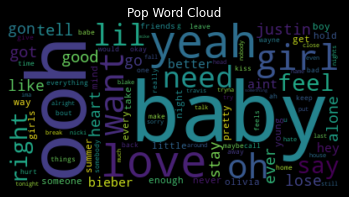

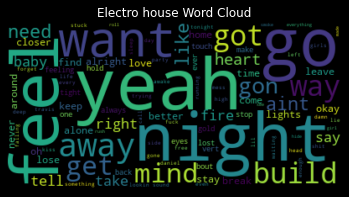

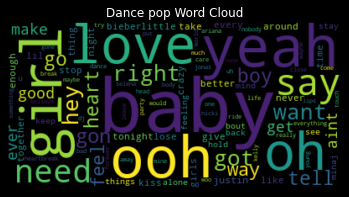

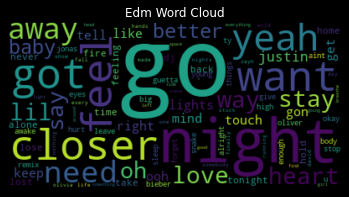

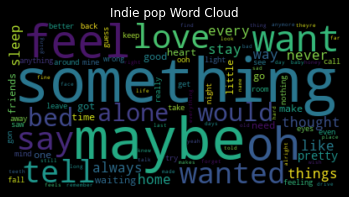

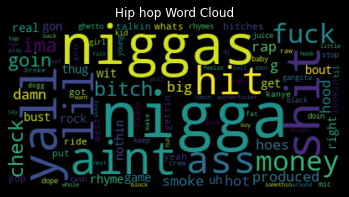

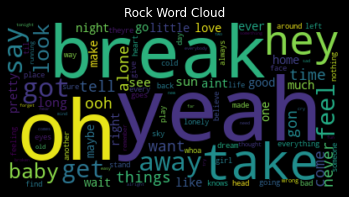

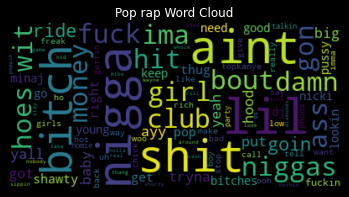

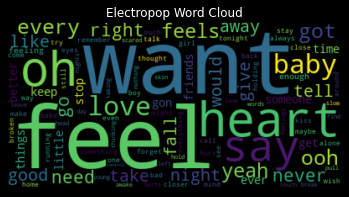

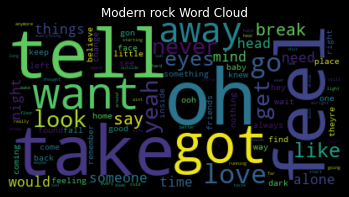

In [6]:

def generateWordCloud(genre):
    return WordCloud(collocations = False, background_color = 'black').generate_from_frequencies(frequencies=dict(TF_IDF[genre].most_common(100)))
NUM_WORDCLOUDS = 10
for genre,_ in genre_song_count.most_common(NUM_WORDCLOUDS):
    word_cloud = generateWordCloud(genre)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"{genre.capitalize()} Word Cloud")
    plt.show()